In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pesq import pesq
import pystoi
from scipy.signal import lfilter, wiener
import scipy.linalg 
from tqdm import tqdm
import time

from utils import load_wav, calculate_snr, itakura_distortion, performance, preemphasis
from sound import Sound
from batch import DataGenerator

from multiprocessing import Pool, cpu_count
import librosa

In [3]:
base_shape_size = 8000

In [4]:
# carrega sons de ruido e sons de voz
sound_base = Sound('/tf/Dados/Vozes/train/', '/tf/Dados/Ruido/train/', base_shape_size)

Loading Noise Files: 100%|██████████| 5695/5695 [00:04<00:00, 1348.54it/s]
/tf/utils/sound.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:74: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]


In [5]:
# Parâmetros do sistema
order = 11  # Ordem da análise LPC
window_size = 600  # Tamanho da janela
sample_rate = 8000  # Taxa de amostragem (exemplo)

In [6]:
data_generator = DataGenerator(sound_base.clean_sounds, sound_base.noise_sounds)

In [7]:
def preemphasis_filter(signal, preemphasis_coeff):
    # Aplicar filtro de pré-ênfase de alta passagem
    preemphasized_signal = np.append(signal[0], signal[1:] - preemphasis_coeff * signal[:-1])
    return preemphasized_signal

In [8]:
def lpc_analysis(signal, order):
    # windowed_signal = preemphasis_filter(signal, 0.83)
    windowed_signal = signal * np.hanning(len(signal))

    a = librosa.lpc(windowed_signal, order=order)

    b = np.hstack([[0], -1 * a[1:]])
    y_hat = scipy.signal.lfilter(b, [1], signal)

    var_residual = np.var(signal - y_hat)

    return a, np.sqrt(var_residual), 0

In [9]:
def build_matrices(A, window_size):
    Ak = np.zeros((order, order))
    Ak[:, 0] = -A[1:]
    Ak[:-1, 1:] = np.eye(order - 1)

    H = np.zeros((1, order))
    H[0, 0] = 1.0

    return Ak, H

In [10]:
def kalman_filter(signal, Ak, H, Q, R):
    x_hat = np.zeros(order)  # Estado estimado
    P = np.eye(order)  # Covariância estimada

    filtered_signal = []

    for sample in signal:
        # Atualização temporal (Predição)
        x_hat = np.dot(Ak, x_hat)
        P = np.dot(np.dot(Ak, P), Ak.T) + Q

        # Atualização de mensuração (Correção)
        K = np.dot(np.dot(P, H.T), np.linalg.inv(np.dot(np.dot(H, P), H.T) + R))
        x_hat = x_hat + np.dot(K, (sample - np.dot(H, x_hat)))
        P = P - np.dot(np.dot(K, H), P)

        filtered_signal.append(x_hat[0])  # Apenas a primeira componente é o sinal estimado

    return np.array(filtered_signal)

In [11]:
def process_signal(signal, window_size, order, sample_rate, SNR_dB=10.):
    filtered_signal = []

    for i in range(0, len(signal), window_size):
        window_samples = signal[i:i+window_size]
        
        # Realizar análise LPC e construir as matrizes Ak e H
        A, sigma, _ = lpc_analysis(window_samples, order)
        Ak, H = build_matrices(A, len(window_samples))

        # Calcular a variância do erro de aquisição R com base no SNR linear
        SNR_linear = 10.0**(SNR_dB / 10.0)
        Rx = 1.0 / SNR_linear
        
        # Calcular Q e R (assumindo que não mudam dentro da janela)
        Q = np.eye(order) * sigma  # Variância do erro de predição
        R = np.eye(1) * Rx  # Variância do erro de aquisição

        # Aplicar o filtro de Kalman na janela
        filtered_window = kalman_filter(window_samples, Ak, H, Q, R)
        filtered_signal.extend(filtered_window)

    return np.array(filtered_signal)

In [21]:
def process_batch(args):
    x_batch, y_batch, SNR_dB_batch, window_size, order, sample_rate = args
    
    start_time = time.time()  # Início da medição de tempo
    filtered_batch = [process_signal(noisy_signal, window_size, order, sample_rate, SNR_dB=SNR_dB) for noisy_signal, SNR_dB in zip(x_batch, SNR_dB_batch)]
    end_time = time.time()  # Fim da medição de tempo
    delta = end_time - start_time
    
    pesq_scores = []#[pesq(8000, clean, filtered.reshape(-1), 'nb') for clean, filtered in zip(y_batch, filtered_batch)]
    stoi_scores = []#[pystoi.stoi(clean, filtered, 8000) for clean, filtered in zip(y_batch, filtered_batch)]
    snr_scores = []#[calculate_snr(clean, filtered) for clean, filtered in zip(y_batch, filtered_batch)]
    ID_scores = []#[1 for clean, filtered in zip(y_batch, filtered_batch)]
    
    # return pesq_scores, stoi_scores, snr_scores, ID_scores
    return delta

In [25]:
batch_num = 40
batch_size=128

# Acumulador para os tempos de execução
execution_times = []
df_resultado = pd.DataFrame()

In [26]:
num_processes = cpu_count()  # Usar o número de núcleos da CPU
    
with Pool(processes=num_processes) as pool:
    results = []
    
    for _ in tqdm(range(batch_num)):
        x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_metrics(window_size, order, batch_size=batch_size))
        SNR_dB_batch = metrics_batch_df['SNR']
        
        args = (x_batch, y_batch, SNR_dB_batch, window_size, order, sample_rate)
        
        result = pool.apply_async(process_batch, (args,))
        
        execution_times.append(result.get())
        # results.append((result, metrics_batch_df))
    
    # df_resultado = pd.DataFrame()
    
    # for result, metrics_batch_df in results:
    #     pesq_scores, stoi_scores, snr_scores, ID_scores = result.get()
    #     metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    #     metrics_batch_df['STOI (Filtered)'] = stoi_scores
    #     metrics_batch_df['SNR (Filtered)'] = snr_scores
    #     metrics_batch_df['ID (Filtered)'] = ID_scores
        
    #     df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

  0%|          | 0/40 [00:00<?, ?it/s]/tf/utils/utils.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  fator_amplitude = np.sqrt(potencia_desejada_ruido / potencia_sinal2)
/tf/utils/utils.py:97: RuntimeWarning: invalid value encountered in multiply
  sinal2_ajustado = sinal2 * fator_amplitude
  5%|▌         | 2/40 [00:54<17:07, 27.03s/it]/usr/local/lib/python3.8/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
100%|██████████| 40/40 [17:24<00:00, 26.12s/it]


In [27]:
average_time = (sum(execution_times) / len(execution_times)) / batch_size
print(f"Tempo médio de execução por iteração: {average_time} segundos")

Tempo médio de execução por iteração: 0.1808137315325439 segundos


In [15]:
# for _ in tqdm(range(batch_num)):
#     x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_metrics(window_size, order, batch_size=128))
                
#     # Aplica o filtro de Kalman aos sinais ruidosos
#     filtered_batch = [process_signal(noisy_signal, window_size, order, sample_rate, SNR_dB=SNR_dB) for noisy_signal, SNR_dB in zip(x_batch, metrics_batch_df['SNR'])]
    
#     # Calcula as métricas para os sinais filtrados
#     pesq_scores = [pesq(8000, clean, filtered.reshape(-1), 'nb') for clean, filtered in zip(y_batch, filtered_batch)]
#     stoi_scores = [pystoi.stoi(clean, filtered, 8000) for clean, filtered in zip(y_batch, filtered_batch)]
#     snr_scores = [calculate_snr(clean, filtered) for clean, filtered in zip(y_batch, filtered_batch)]
#     ID_scores = [itakura_distortion(clean, filtered, window_size, order) for clean, filtered in zip(y_batch, filtered_batch)]
    
#     # Adiciona as métricas dos sinais filtrados ao DataFrame
#     metrics_batch_df['PESQ (Filtered)'] = pesq_scores
#     metrics_batch_df['STOI (Filtered)'] = stoi_scores
#     metrics_batch_df['SNR (Filtered)'] = snr_scores
#     metrics_batch_df['ID (Filtered)'] = ID_scores

#     df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

In [16]:
df_resultado

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
0,7.0,20.0,1.948757,0.860023,6.742480,1,2.011962,0.877808,7.478316,1
1,16.0,19.0,1.988582,0.854737,14.224888,1,1.984531,0.857489,14.523243,1
2,12.0,21.0,2.333347,0.979676,11.443686,1,2.383271,0.980669,12.883069,1
3,17.0,21.0,2.925854,0.988331,15.528902,1,2.980886,0.987743,16.061775,1
4,19.0,18.0,2.574918,0.950585,15.487648,1,2.669372,0.957468,16.235795,1
...,...,...,...,...,...,...,...,...,...,...
5037,16.0,18.0,2.639511,0.950110,13.812296,1,2.666939,0.951449,14.107301,1
5038,8.0,23.0,2.191564,0.959532,7.819487,1,2.348366,0.955433,8.477721,1
5039,12.0,24.0,2.953543,0.971277,11.688657,1,3.064145,0.971670,12.297529,1
5040,13.0,15.0,1.657883,0.939408,10.809197,1,1.781350,0.943985,10.600535,1


In [17]:
df_resultado.describe()

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
count,5042.000000,5042.000000,5042.000000,5042.000000,5042.000000,5042.0,5042.000000,5042.000000,5042.000000,5042.0
mean,9.468663,19.458350,2.057452,0.860846,8.568157,1.0,2.130065,0.858160,9.505743,1.0
std,5.778589,2.874404,0.466033,0.122965,5.041420,0.0,0.481709,0.125666,4.599316,0.0
min,0.000000,15.000000,1.075590,0.000010,-0.306025,1.0,1.058432,0.000010,-1.149386,1.0
25%,5.000000,17.000000,1.722437,0.812157,4.441528,1.0,1.789344,0.809396,5.622125,1.0
50%,10.000000,19.000000,2.001639,0.894307,8.844783,1.0,2.082465,0.892698,9.734549,1.0
75%,14.000000,22.000000,2.334235,0.946751,12.841471,1.0,2.426608,0.945497,13.423737,1.0
max,19.000000,24.000000,4.436897,0.999024,17.906677,1.0,4.373120,0.998970,18.792391,1.0


In [18]:
# index = 6
# start = 2500
# end = start + 750

# # Plote o sinal original e o sinal do LPC gerado
# plt.figure(figsize=(10, 6))

# # Plote o sinal original
# plt.subplot(3, 1, 1)
# plt.plot(y_batch[index][start:end], label='Sinal Original', color='blue')
# plt.title('Sinal Original')
# plt.xlabel('Amostras')
# plt.ylabel('Amplitude')
# plt.legend()

# # Plote o sinal do LPC gerado
# plt.subplot(3, 1, 2)
# plt.plot(x_batch[index][start:end], label='Sinal Ruidoso', color='red')
# plt.title('Sinal Ruidoso')
# plt.xlabel('Amostras')
# plt.ylabel('Amplitude')
# plt.legend()

# # Plote o sinal do LPC gerado
# plt.subplot(3, 1, 3)
# plt.plot(filtered_batch[index][start:end], label='Sinal Filtrado', color='green')
# plt.title('Sinal Filtrado')
# plt.xlabel('Amostras')
# plt.ylabel('Amplitude')
# plt.legend()

# plt.tight_layout()
# plt.show()

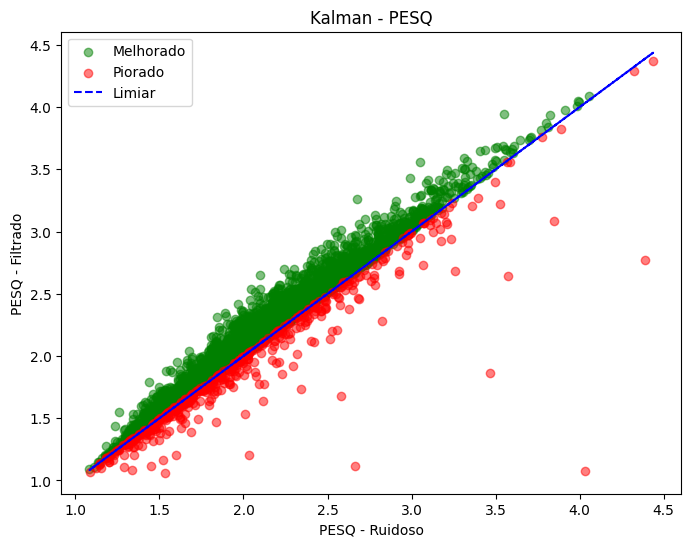

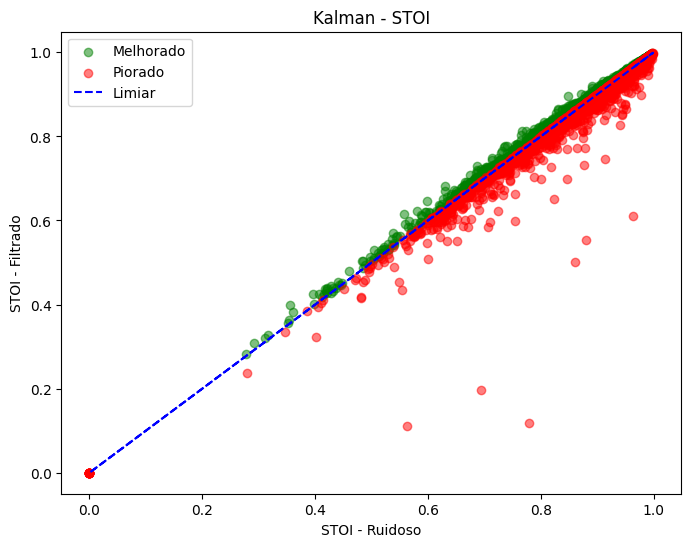

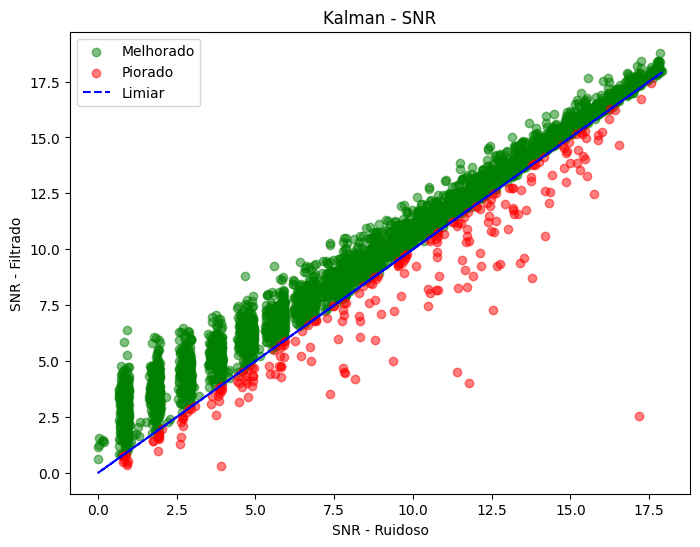

In [19]:
performance(df_resultado, 'Kalman')

In [36]:
from datetime import datetime

In [37]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Define the file name with the datetime
file_name = f"kalman_{datetime_str}.xlsx"

In [38]:
df_resultado.to_excel(file_name, index=False)